In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [5]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 45.8 s


In [6]:
import h5py
hf = h5py.File('HamiltonianConstructionTerms.h5', 'w')
hf.create_dataset('Hff', data = HamiltonianJ6.Hff_m)
hf.create_dataset('HSx', data = HamiltonianJ6.HSx_m)
hf.create_dataset('HSy', data = HamiltonianJ6.HSy_m)
hf.create_dataset('HSz', data = HamiltonianJ6.HSz_m)
hf.create_dataset('HZx', data = HamiltonianJ6.HZx_m)
hf.create_dataset('HZy', data = HamiltonianJ6.HZy_m)
hf.create_dataset('HZz', data = HamiltonianJ6.HZz_m)
hf.close()

In [7]:
Hterms = (HamiltonianJ6.Hff_m, HamiltonianJ6.HSx_m, HamiltonianJ6.HSy_m, HamiltonianJ6.HSz_m, 
          HamiltonianJ6.HZx_m, HamiltonianJ6.HZy_m, HamiltonianJ6.HZz_m)

# Generating Trajectories and Interpolating Fields

Simple trajectory generating function, simply straight though the lens without any bending to make comparisons simpler

In [8]:
from scipy.interpolate import interp1d

x = np.linspace(-0.008, 0.008, int(np.sqrt(500)))
y = np.linspace(-0.013, 0.013, int(np.sqrt(500)))

def generateTrajectory(x,y):
    tmax = 0.9/200
    t = np.linspace(0,tmax,100)    
    intTrajX = interp1d(t, np.ones(len(t))*x, kind = 'linear')
    intTrajY = interp1d(t, np.ones(len(t))*y, kind = 'linear')
    intTrajZ = interp1d(t, -0.45+t*200, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tmax

Generating the trajectories

In [9]:
import itertools
interpolateTrajectories = []
for xi, yi in itertools.product(x,y):
    interpolateTrajectories.append((generateTrajectory(xi,yi)))

In [10]:
import pickle
with open('trajectoriesStraight', 'wb') as wfp:
    pickle.dump(interpolateTrajectories, wfp)

In [1]:
from fields import *
field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes_offset_1kV.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [12]:
with open('interpolatePotential_homogeneous_offset_1kV', 'wb') as wfp:
    pickle.dump((c, intfun, cP, intfunP), wfp)

# Propagation

# Multiprocessing

# Offset homogeneous field by +1kV

In [13]:
from tqdm import tqdm_notebook as tqdm

def progress_thread(q, total, workers):
    """
    Creating a progress bar using tqdm usable over multiple processes
    """
    done = 0
    pbar = tqdm(total=total)
    while True:
        val = q.get()
        if val != None:
            pbar.update(1)
        else:
            done += 1
        if done == workers:
            pbar.close()
            break

In [14]:
def prepare_ranges(workers, totRange):
    if workers > 1:
        ranges = [(i*int(totRange/(workers)), ((i+1)*int(totRange/(workers)))) for i in range(workers-1)]
        ranges.append((ranges[-1][-1],totRange))
    else:
        ranges = [(0, totRange)]
    return ranges

In [15]:
def combine_multipool(results):
    idT_list, phi0_list, phi_list, H0_list, H_list = [], [], [], [], []
    for idx in range(len(results)):
        idT_list.extend(results[idx][0])
        phi0_list.extend(results[idx][1])
        phi_list.extend(results[idx][2])
        H0_list.extend(results[idx][3])
        H_list.extend(results[idx][4])
    return idT_list, phi0_list, phi_list, H0_list, H_list

In [16]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 5
# level to propagate
start_level = 35
# total trajectories
nrTrajectories = len(interpolateTrajectories)

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesStraight', 'interpolatePotential_homogeneous_offset_1kV', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [17]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [18]:
import h5py
def save_to_hdf(fname, data):
    idT_list, phi0_list, phi_list, H0_list, H_list = data
    hf = h5py.File(fname, 'w')
    hf.create_dataset('idT', data = idT_list)
    hf.create_dataset('phi0', data = phi0_list)
    hf.create_dataset('phi', data = phi_list)
    hf.create_dataset('H0', data = H0_list)
    hf.create_dataset('H', data = H_list)
    hf.close()

In [19]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_1kVoffset.h5'
save_to_hdf(data_dir+fname, (idT_list, phi0_list, phi_list, H0_list, H_list))

In [20]:
def load_from_hdf(fname):
    hf = h5py.File(fname, 'r')
    idT_list = hf['idT'].value
    phi0_list = hf['phi0'].value
    phi_list = hf['phi'].value
    H0_list = hf['H0'].value
    H_list = hf['H'].value
    hf.close()
    return idT_list, phi0_list, phi_list, H0_list, H_list

In [21]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_1kVoffset.h5'
idT_list, phi0_list, phi_list, H0_list, H_list = load_from_hdf(data_dir+fname)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [22]:
idL = 1
np.abs(phi_list[idL].conj()@phi0_list[idL])**2

0.9895059916794378

In [23]:
nrTrajectories = len(interpolateTrajectories)
tmp = []
for idL in range(nrTrajectories):
    tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)

0.9441047573099983


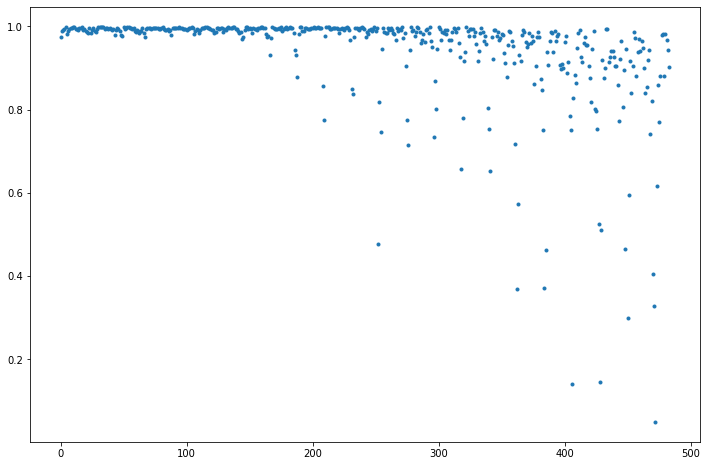

In [24]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(tmp, '.')
print(np.mean(tmp))

In [25]:
from scipy.interpolate import griddata
from matplotlib import colors

def create_grid_trajectories(interpolateTrajectories, probabilities):
    x0 = []
    y0 = []
    for idL in range(len(interpolateTrajectories)):
        traj = interpolateTrajectories[idL]
        x0.append(traj[0](0.000))
        y0.append(traj[1](0.000))
    x0 = np.array(x0)
    y0 = np.array(y0)
    
    dx = np.min(np.abs(np.diff(x0)[np.diff(x0) != 0]))
    dy = np.min(np.abs(np.diff(y0)[np.diff(y0) != 0]))
    
    xi = np.linspace(x0.min(), x0.max(), int(np.sqrt(500))*2)
    yi = np.linspace(y0.min(), y0.max(), int(np.sqrt(500))*2)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x0,y0), probabilities, (X,Y), method = 'linear')
    return x0,y0,xi,yi,X,Y,Z
    
def plot_grid_trajectories(interpolateTrajectories, probabilities):
    x0,y0,xi,yi,X,Y,Z = create_grid_trajectories(interpolateTrajectories, probabilities)
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z)
    vmin, vmax = cax.get_clim()
    ax.scatter(x0, y0, c = probabilities, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('probability', fontsize = 15)
    cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
    cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('Probability to stay in state', fontsize = 15);
    ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)
    ax.set_aspect(1/1.35)

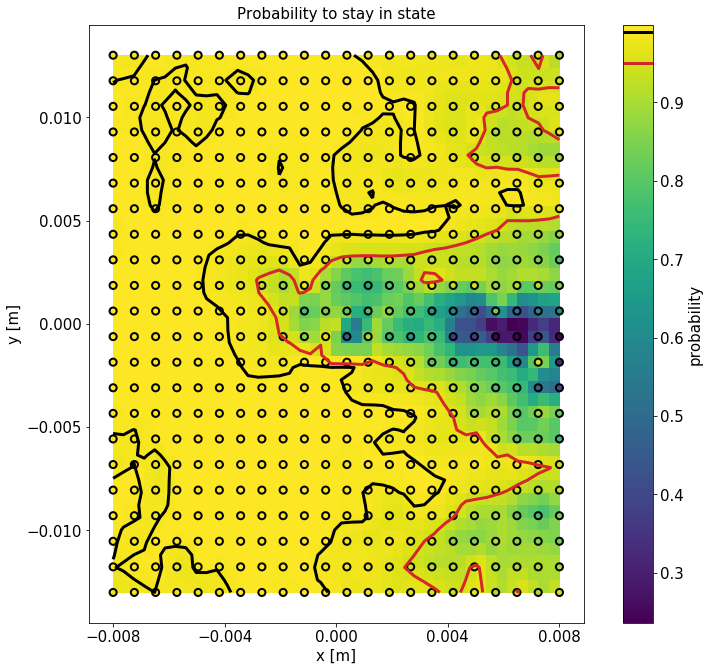

In [26]:
plot_grid_trajectories(interpolateTrajectories, tmp)

In [27]:
def plot_trajectory(traj, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, traj[0](t), lw = 3)
    axs[0][1].plot(t, traj[1](t), lw = 3)
    axs[1][0].plot(t, traj[2](t), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'x,y,z'.split(',')):
        ax.set_ylabel(f'{ylabel} [m]')

    fig.delaxes(axs[1][1])

worst trajectory : 472


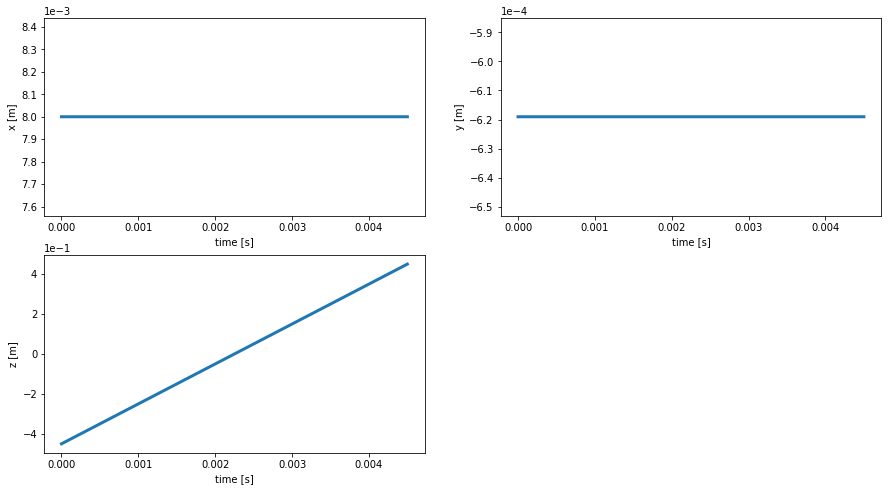

In [28]:
idmin = np.argmin(tmp)
print(f'worst trajectory : {idmin}')
traj = interpolateTrajectories[idmin]
plot_trajectory(traj)

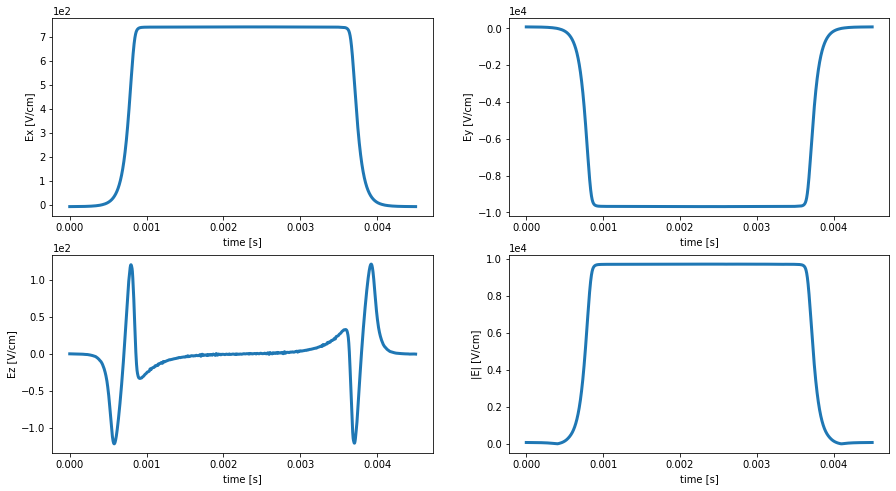

In [29]:
def plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, funEx(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[0][1].plot(t, funEy(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][0].plot(t, funEz(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][1].plot(t, funEmag(traj[0](t), traj[1](t), traj[2](t)), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'Ex,Ey,Ez,|E|'.split(',')):
        ax.set_ylabel(f'{ylabel} [V/cm]')

plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag)

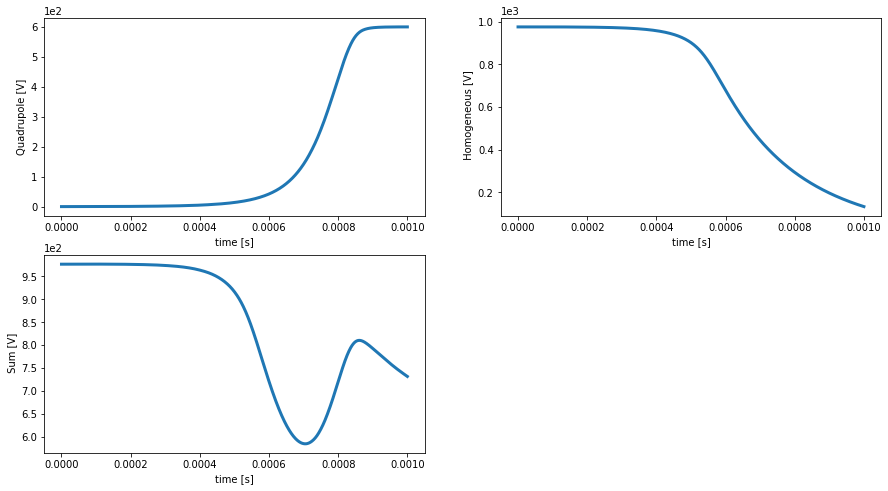

In [30]:
def plot_potential_trajectory(traj, intfun, intfunP, c, cP, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
        
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, intfun(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),c), lw = 3)
    axs[0][1].plot(t, intfunP(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),cP), lw = 3)
    axs[1][0].plot(t, intfun(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),c)+
                      intfunP(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),cP), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'Quadrupole, Homogeneous, Sum'.split(',')):
        ax.set_ylabel(f'{ylabel} [V]')

    fig.delaxes(axs[1][1])

plot_potential_trajectory(traj, intfun, intfunP, c, cP, t = np.linspace(0, 0.001, 1000))

In [31]:
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

def Erotation(traj, t):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
    return t[1:], angle, angle/np.diff(t)

def ErotationInit(traj, t):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[0:1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[0:1,:], axis = 1)))
    return t[1:], angle

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':


field max rotation speed : 9.72e+03 V/cm @1.45e-03 s


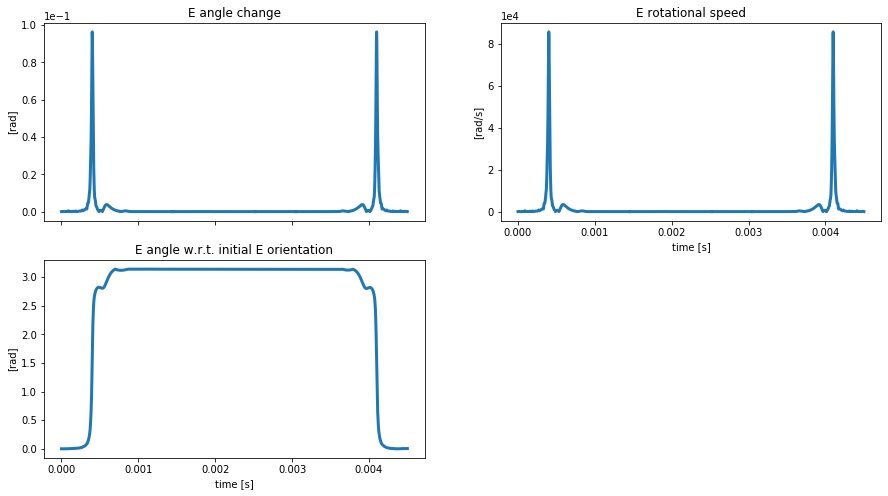

In [32]:
def plot_field_rotation_trajectory(traj, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
        
    tangle, angle, speed = Erotation(traj, t)
    tangle, angle_init = ErotationInit(traj, t)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(tangle, angle, lw = 3)
    axs[0][1].plot(tangle, speed, lw = 3)
    axs[1][0].plot(tangle, angle_init, lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))

    for ax, ylabel in zip(axs.flat, '[rad],[rad/s],[rad]'.split(',')):
        ax.set_ylabel(f'{ylabel}')

    for ax, title in zip(axs.flat, 'E angle change,E rotational speed,E angle w.r.t. initial E orientation'.split(',')):
        ax.set_title(f'{title}')

    plt.setp(axs[0][0].get_xticklabels(), visible=False)
    axs[0][0].set_xlabel('')

    fig.delaxes(axs[1][1])
    
    ti = tangle[np.argmax(speed)]
    field_max_speed = funEmag(traj[0](ti), traj[1](ti), traj[2](ti))
    print(f'field max rotation speed : {field_max_speed:.2e} V/cm @{ti:.2e} s')

plot_field_rotation_trajectory(traj)

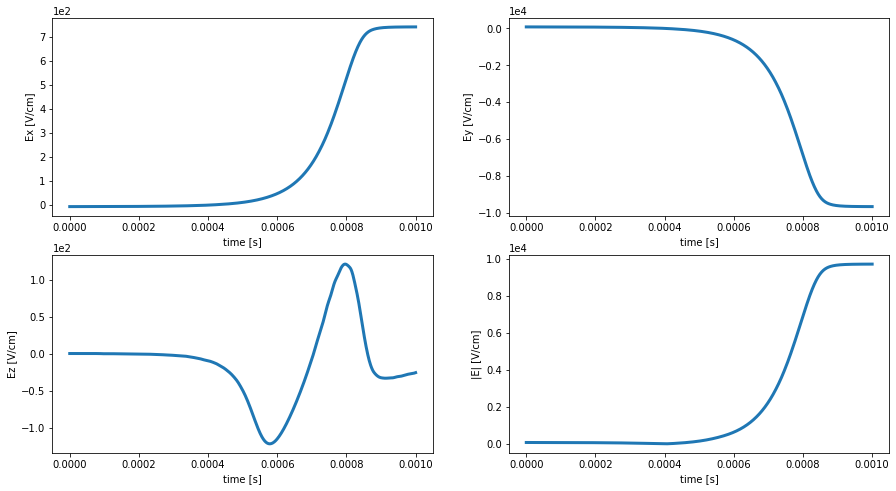

In [33]:
plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = np.linspace(0, 0.001, 1000))

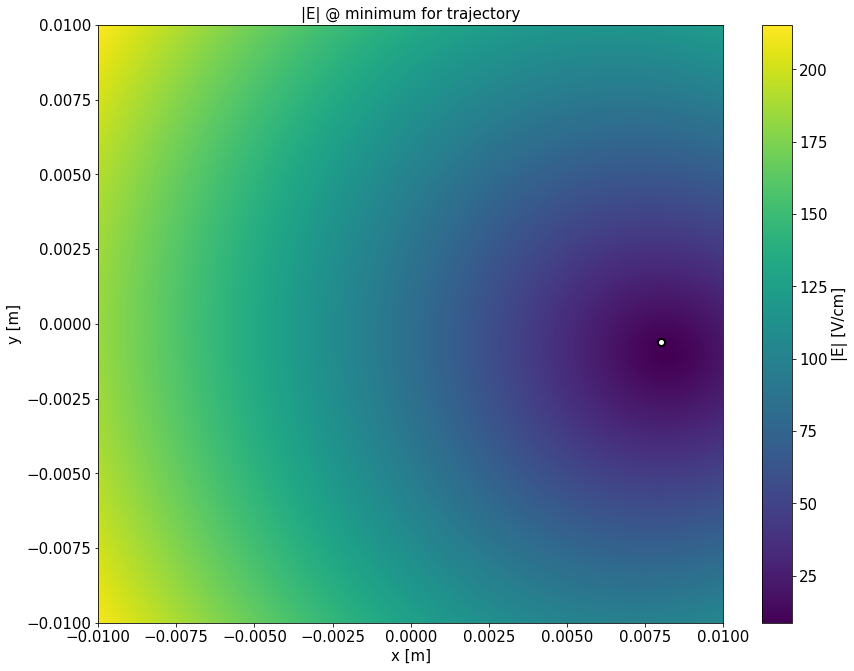

In [34]:
from scipy.interpolate import griddata

def plot_E_xyplane(traj):
    t = np.linspace(0,traj[-1],10000)
    xi, yi = np.linspace(-0.01, 0.01, 1000), np.linspace(-0.01, 0.01, 1000)
    X,Y = np.meshgrid(xi,yi)
    tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
    Z = funEmag(X,Y,traj[2](tmin))

    # from matplotlib import colors
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
    vmin, vmax = cax.get_clim()
    ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('|E| [V/cm]', fontsize = 15)
    # cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('|E| @ minimum for trajectory', fontsize = 15);
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)

plot_E_xyplane(traj)

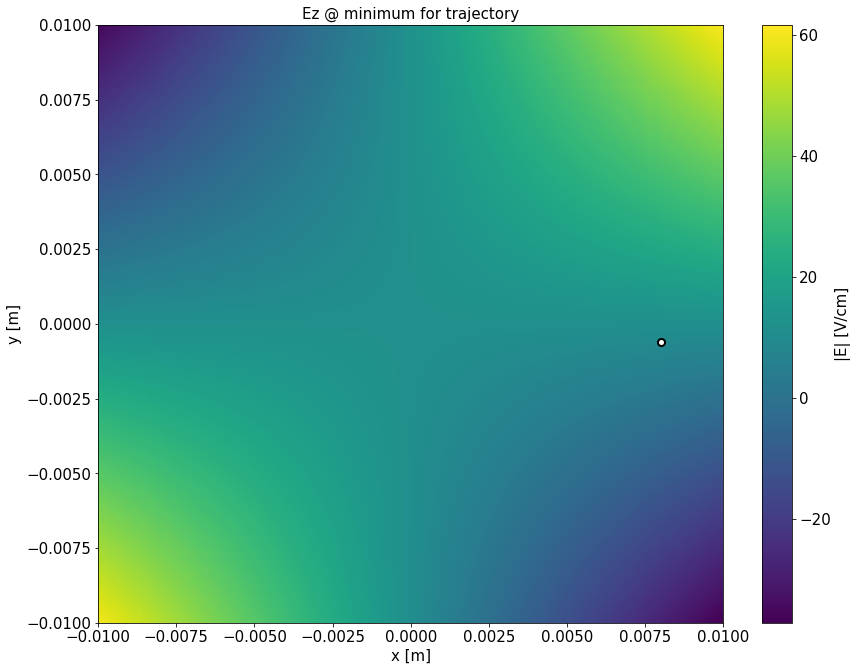

In [35]:
def plot_Ez_xyplane(traj):
    t = np.linspace(0,traj[-1],10000)
    xi, yi = np.linspace(-0.01, 0.01, 200), np.linspace(-0.01, 0.01, 200)
    X,Y = np.meshgrid(xi,yi)
    tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
    Z = funEz(X,Y,traj[2](tmin))

    # from matplotlib import colors
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
    vmin, vmax = cax.get_clim()
    ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('|E| [V/cm]', fontsize = 15)
    # cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('Ez @ minimum for trajectory', fontsize = 15);
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)

plot_Ez_xyplane(traj)

# Offset homogeneous field by -1kV

In [6]:
import pickle
from fields import *

field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes_offset_-1kV.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

with open('interpolatePotential_homogeneous_offset_-1kV', 'wb') as wfp:
    pickle.dump((c, intfun, cP, intfunP), wfp)

In [37]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 6
# level to propagate
start_level = 35
# total trajectories
nrTrajectories = len(interpolateTrajectories)

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesStraight', 'interpolatePotential_homogeneous_offset_-1kV', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [38]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [39]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_-1kVoffset.h5'
save_to_hdf(data_dir+fname, (idT_list, phi0_list, phi_list, H0_list, H_list))

In [40]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_-1kVoffset.h5'
idT_list, phi0_list, phi_list, H0_list, H_list = load_from_hdf(data_dir+fname)

0.9526619906915946


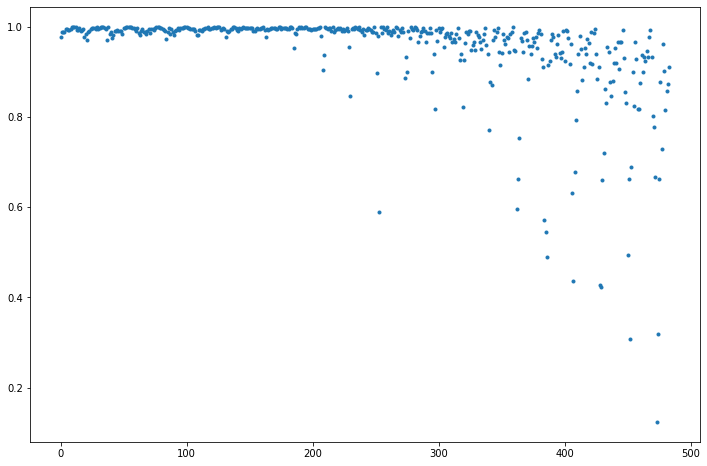

In [41]:
nrTrajectories = len(idT_list)
tmp = []
for idL in range(nrTrajectories):
    tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(tmp, '.')
print(np.mean(tmp))

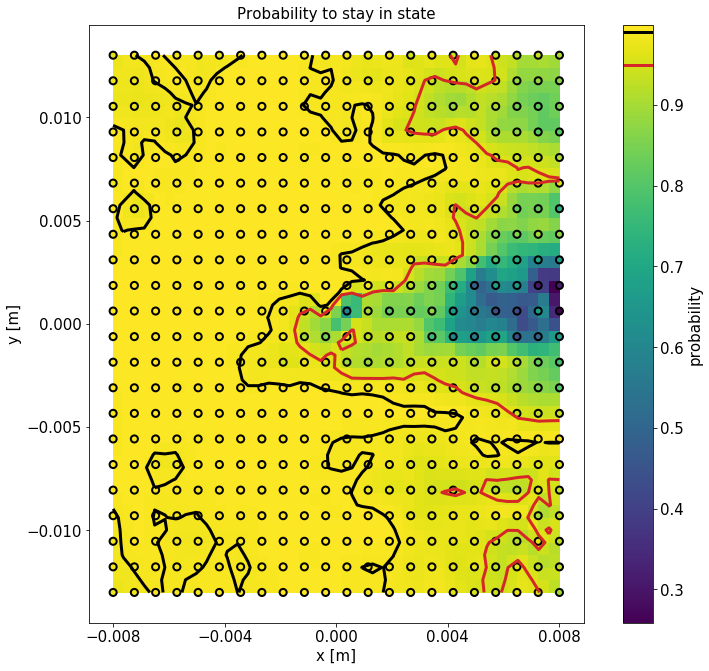

In [42]:
plot_grid_trajectories(interpolateTrajectories, tmp)

field max rotation speed : 1.11e+01 V/cm @4.10e-03 s


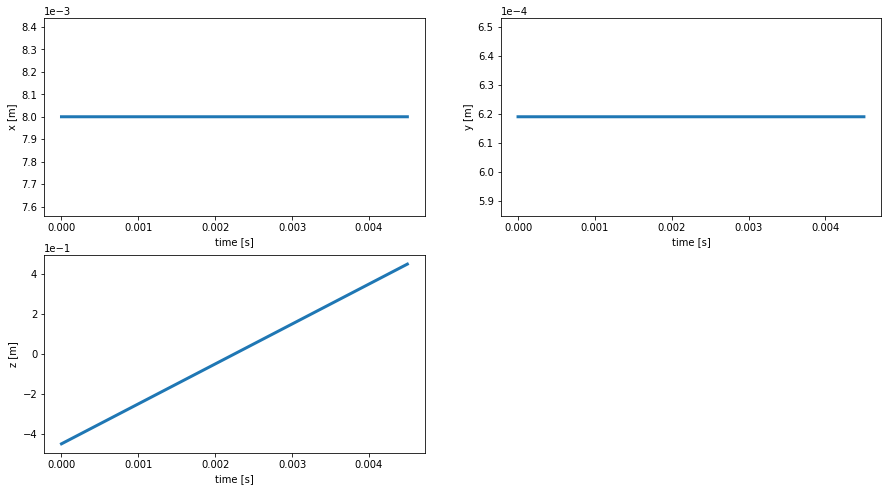

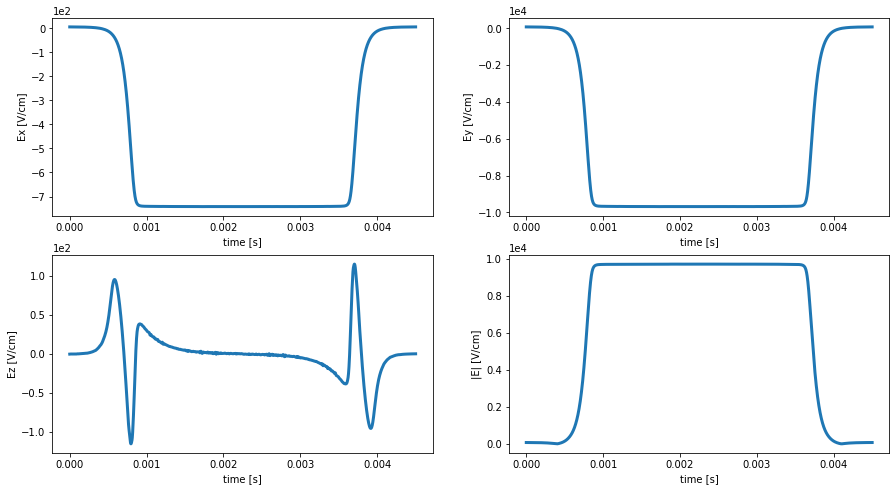

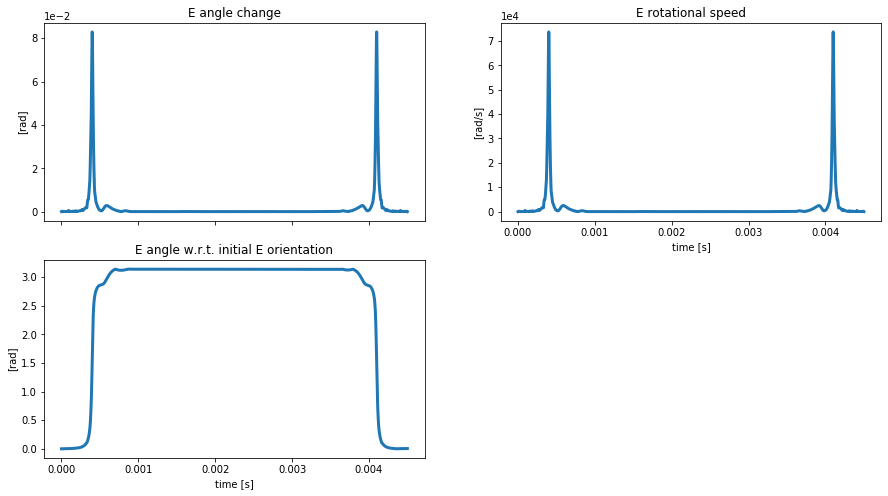

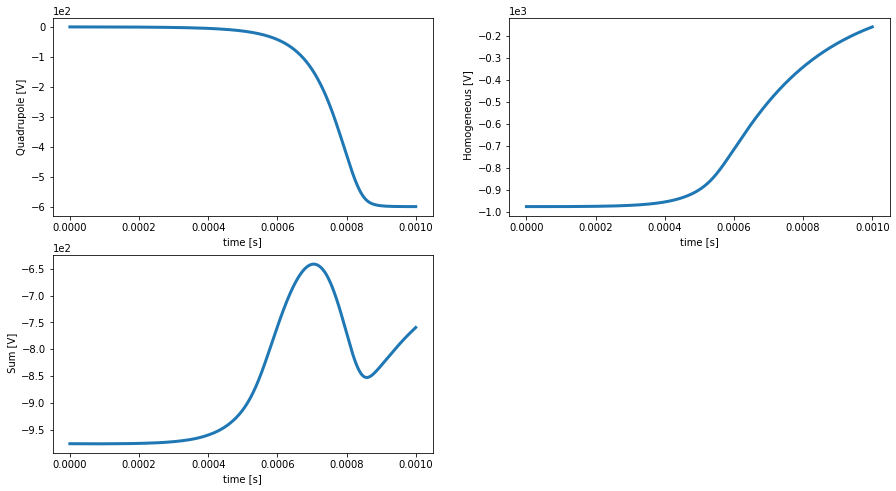

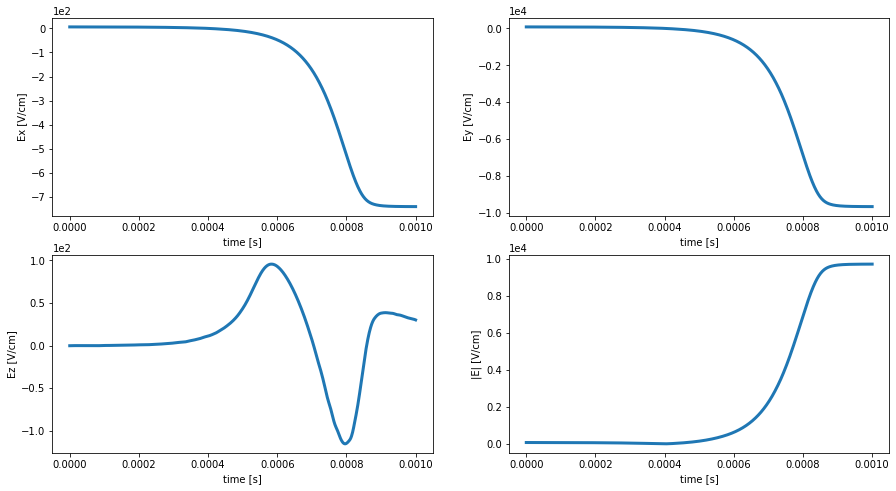

In [43]:
idmin = np.argmin(tmp)
traj = interpolateTrajectories[idmin]
plot_trajectory(traj)

plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag)

plot_field_rotation_trajectory(traj)

plot_potential_trajectory(traj, intfun, intfunP, c, cP, t = np.linspace(0, 0.001, 1000))

plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = np.linspace(0, 0.001, 1000))

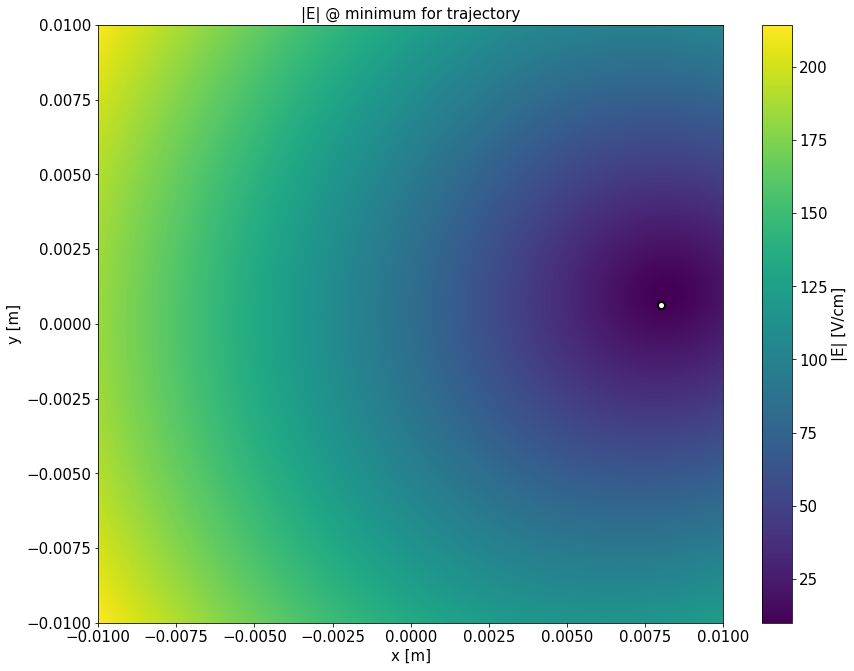

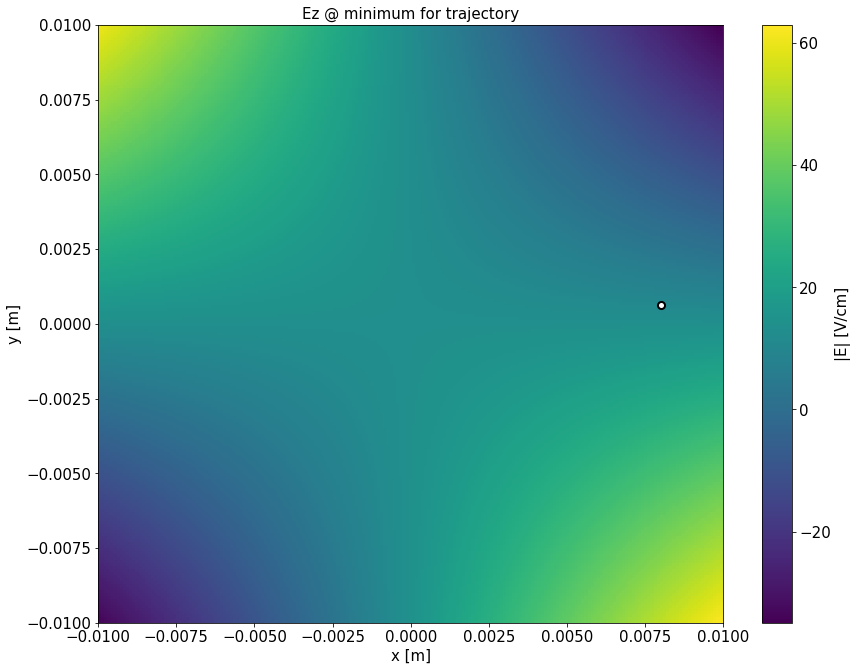

In [44]:
plot_E_xyplane(traj)
plot_Ez_xyplane(traj)

# Offset homogeneous field by -15kV

In [45]:
from fields import *
field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes_offset_-15kV.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

with open('interpolatePotential_homogeneous_offset_-15kV', 'wb') as wfp:
    pickle.dump((c, intfun, cP, intfunP), wfp)

In [46]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 6
# level to propagate
start_level = 35
# total trajectories
nrTrajectories = len(interpolateTrajectories)

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesStraight', 'interpolatePotential_homogeneous_offset_-15kV', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [47]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [48]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_-15kVoffset.h5'
save_to_hdf(data_dir+fname, (idT_list, phi0_list, phi_list, H0_list, H_list))

In [49]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities545_200V_20G_5cm_-15kVoffset.h5'
idT_list, phi0_list, phi_list, H0_list, H_list = load_from_hdf(data_dir+fname)

0.8765464880492602


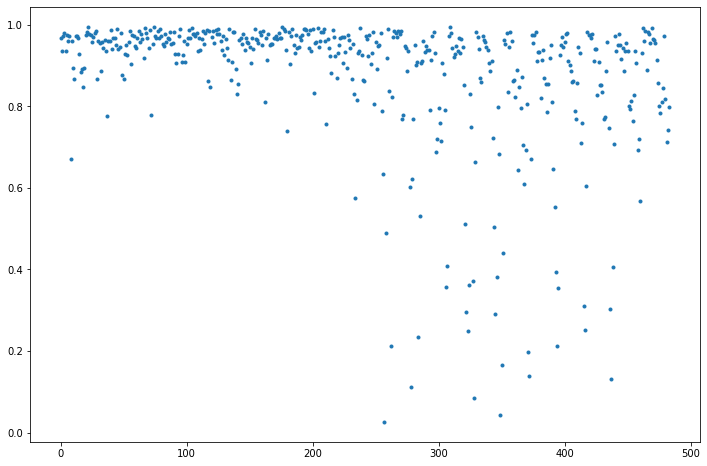

In [50]:
nrTrajectories = len(idT_list)
tmp = []
for idL in range(nrTrajectories):
    tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(tmp, '.')
print(np.mean(tmp))

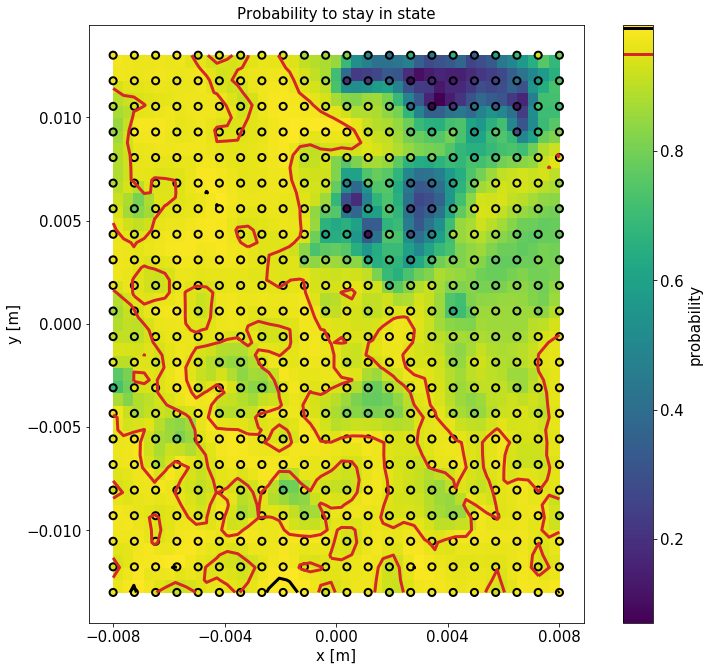

In [51]:
plot_grid_trajectories(interpolateTrajectories, tmp)

field max rotation speed : 3.35e+01 V/cm @4.45e-03 s


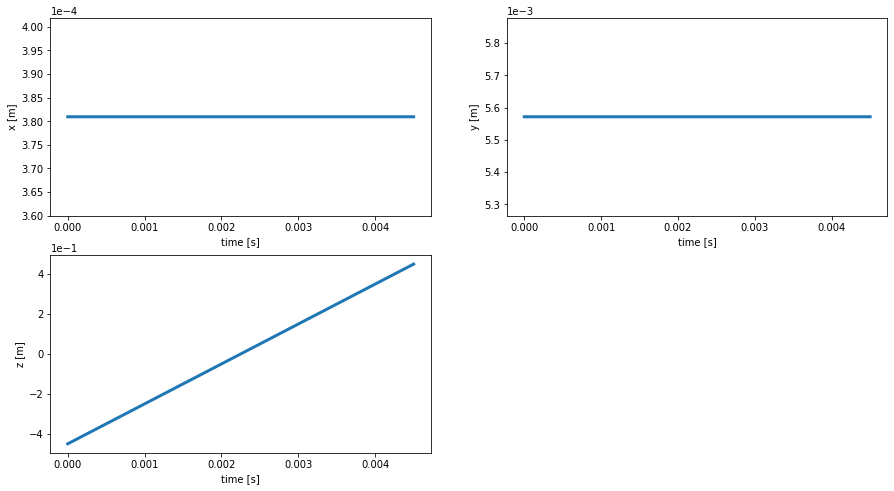

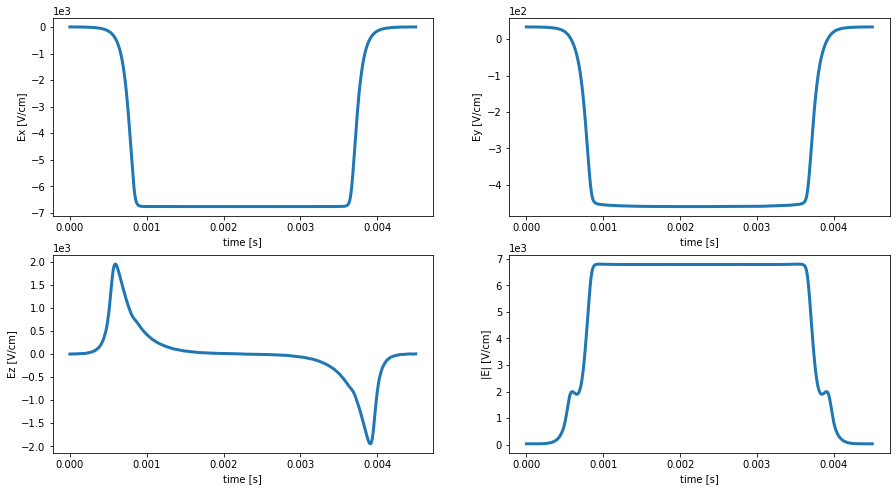

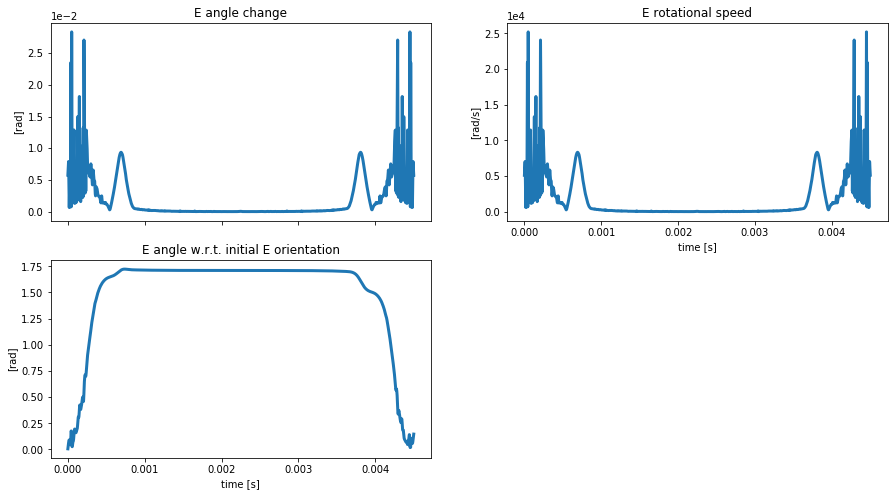

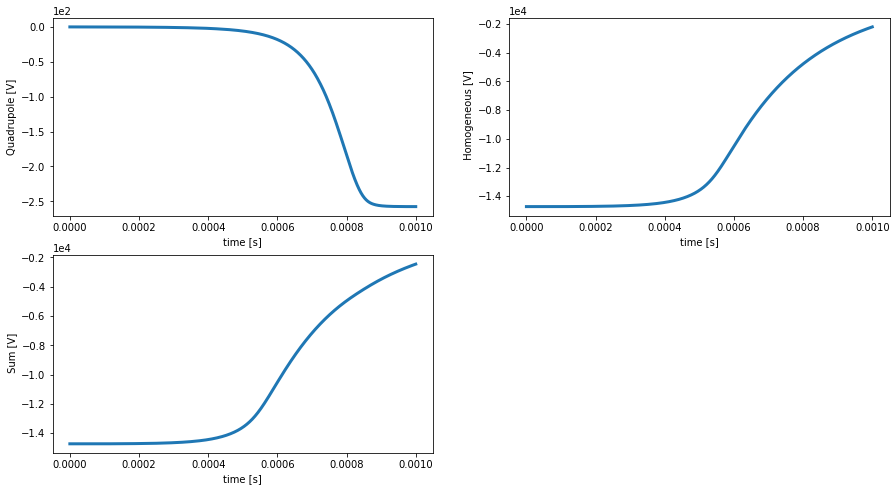

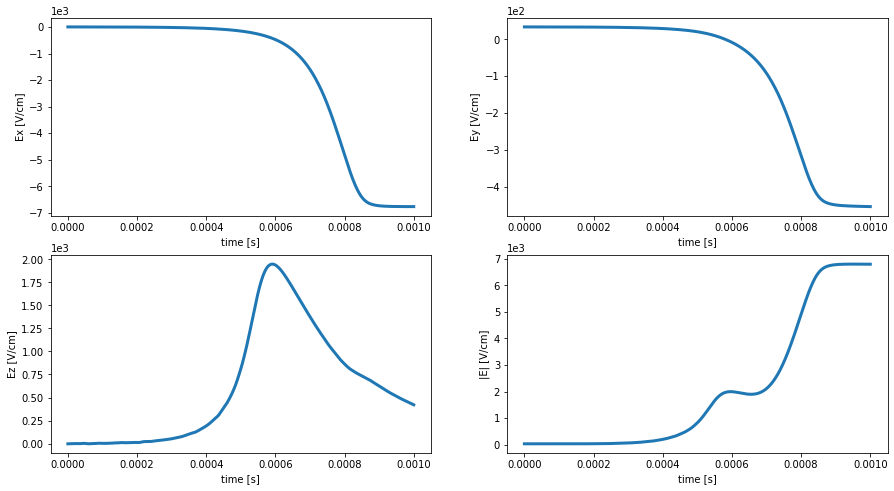

In [52]:
idmin = np.argmin(tmp)
traj = interpolateTrajectories[idmin]
plot_trajectory(traj)

plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag)

plot_field_rotation_trajectory(traj)

plot_potential_trajectory(traj, intfun, intfunP, c, cP, t = np.linspace(0, 0.001, 1000))

plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = np.linspace(0, 0.001, 1000))

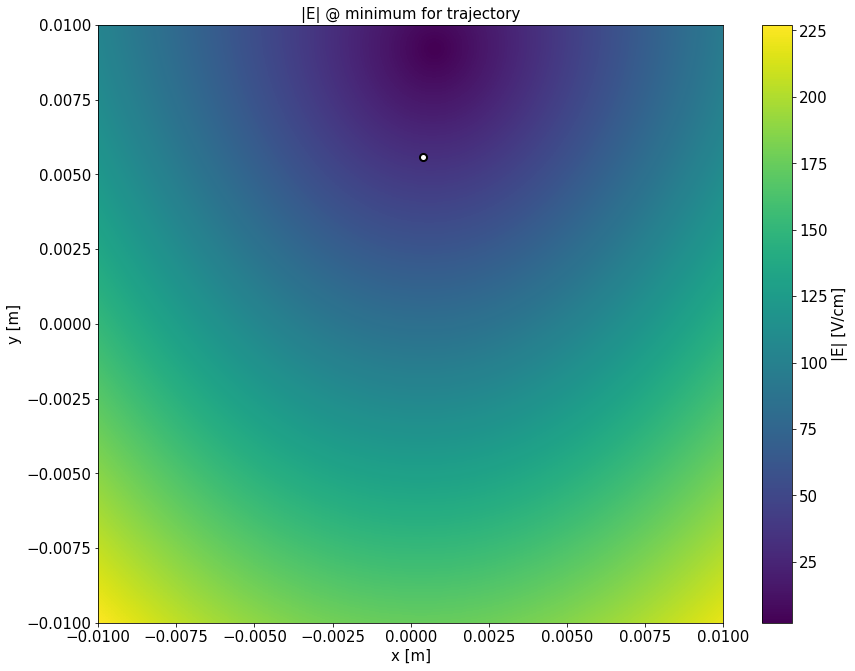

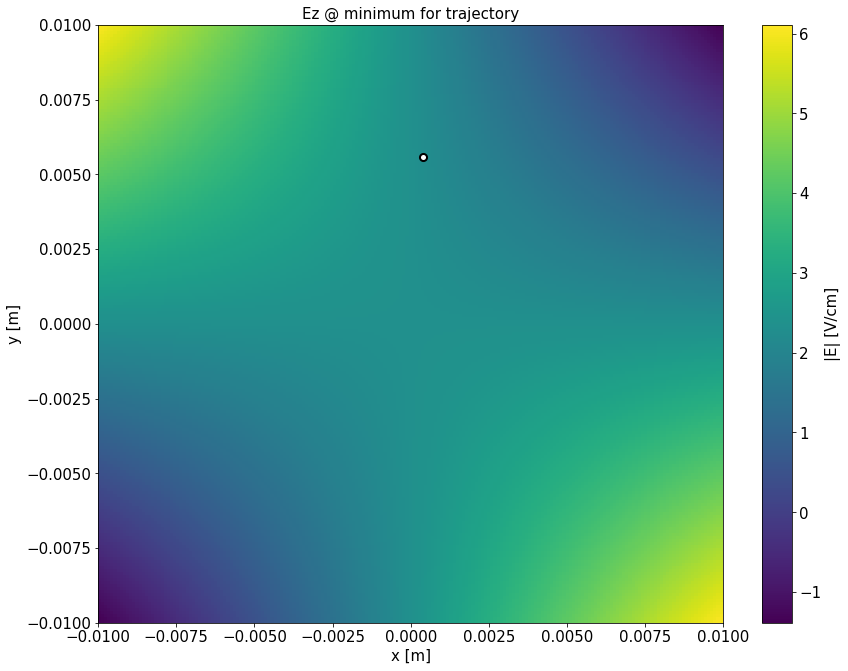

In [53]:
plot_E_xyplane(traj)
plot_Ez_xyplane(traj)